In [1]:
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import os
import glob
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, dpi_save=600)
sc.logging.print_versions()


from collections import defaultdict

/opt/conda/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


In [2]:
adata = sc.read(
    '/home/bay001/projects/kris_apobec_20200121/permanent_data2/04_scRNA_RBFOX2_TIA/inputs/from_alex/02_02_Merge_APO_with_RBFOX_TIA_edits_over_Cs_adata.h5ad'
)
adata

AnnData object with n_obs × n_vars = 22584 × 1964 
    obs: 'batch', 'n_edits', 'n_genes', 'X_umap', 'Y_umap', 'X_pca', 'Y_pca', 'feature', 'RBFOX2_ORF', 'TIA1_ORF', 'louvain_r3', 'louvain_r2', 'louvain_r15', 'louvain_r12', 'louvain', 'louvain_r0.5', 'louvain_r0.2'
    var: 'n_cells-Apo-Edits', 'n_cells-RBFOX_TIA-Edits'
    uns: 'batch_colors', 'feature_colors', 'louvain', 'louvain_colors', 'louvain_r0.2_colors', 'louvain_r0.5_colors', 'louvain_r12_colors', 'louvain_r15_colors', 'louvain_r2_colors', 'louvain_r3_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

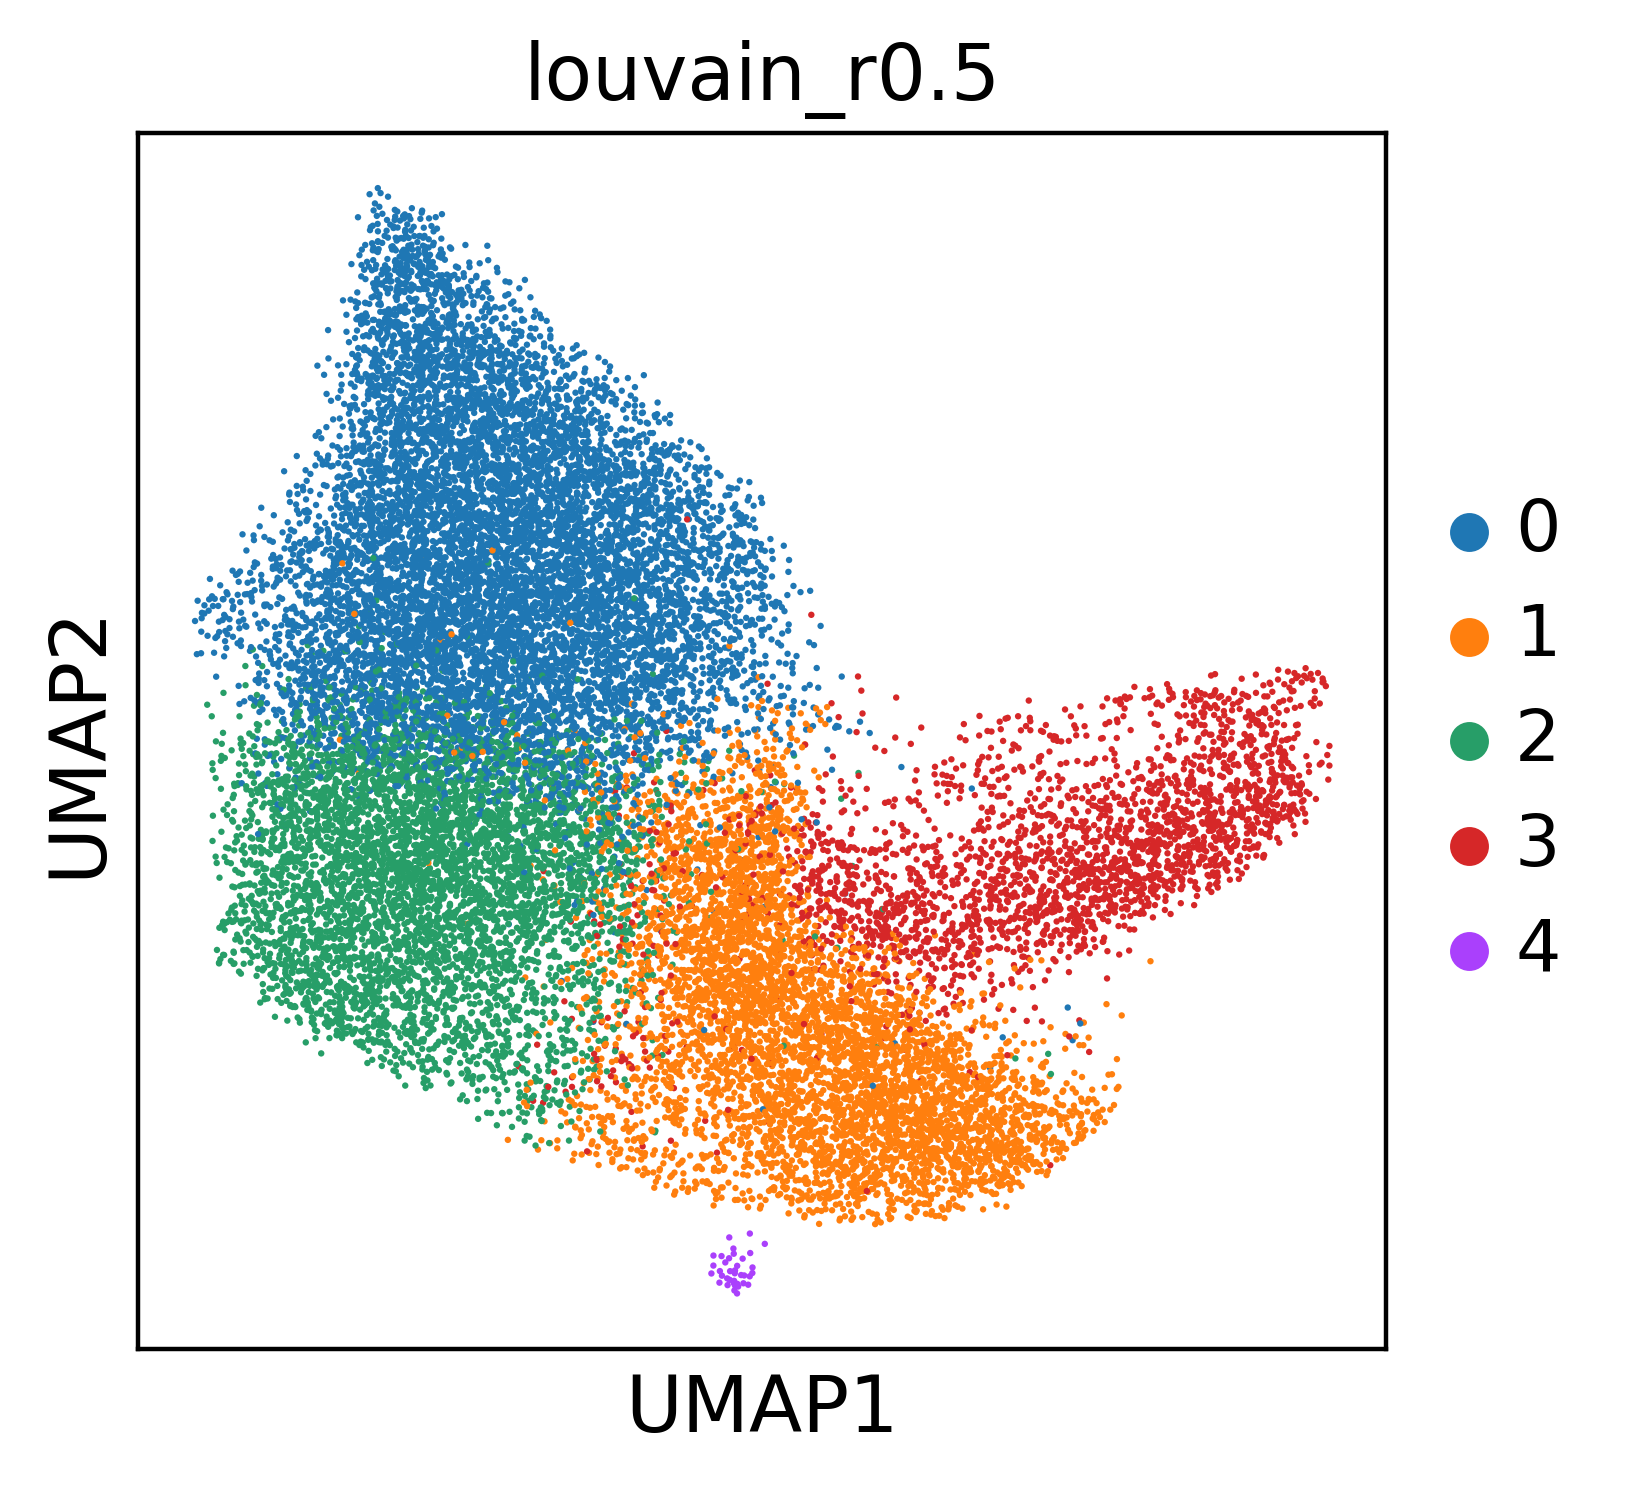

In [3]:
sc.pl.umap(adata, color=['louvain_r0.5'])

In [4]:
adata.obs['new_clusters'] = (
    adata.obs['louvain_r0.5']
    .map(lambda x: {'0':'2'}.get(x, x))
    .astype("category")
)

In [5]:
adata.obs['new_clusters'] = (
    adata.obs['new_clusters']
    .map(lambda x: {'1':'4'}.get(x, x))
    .astype("category")
)

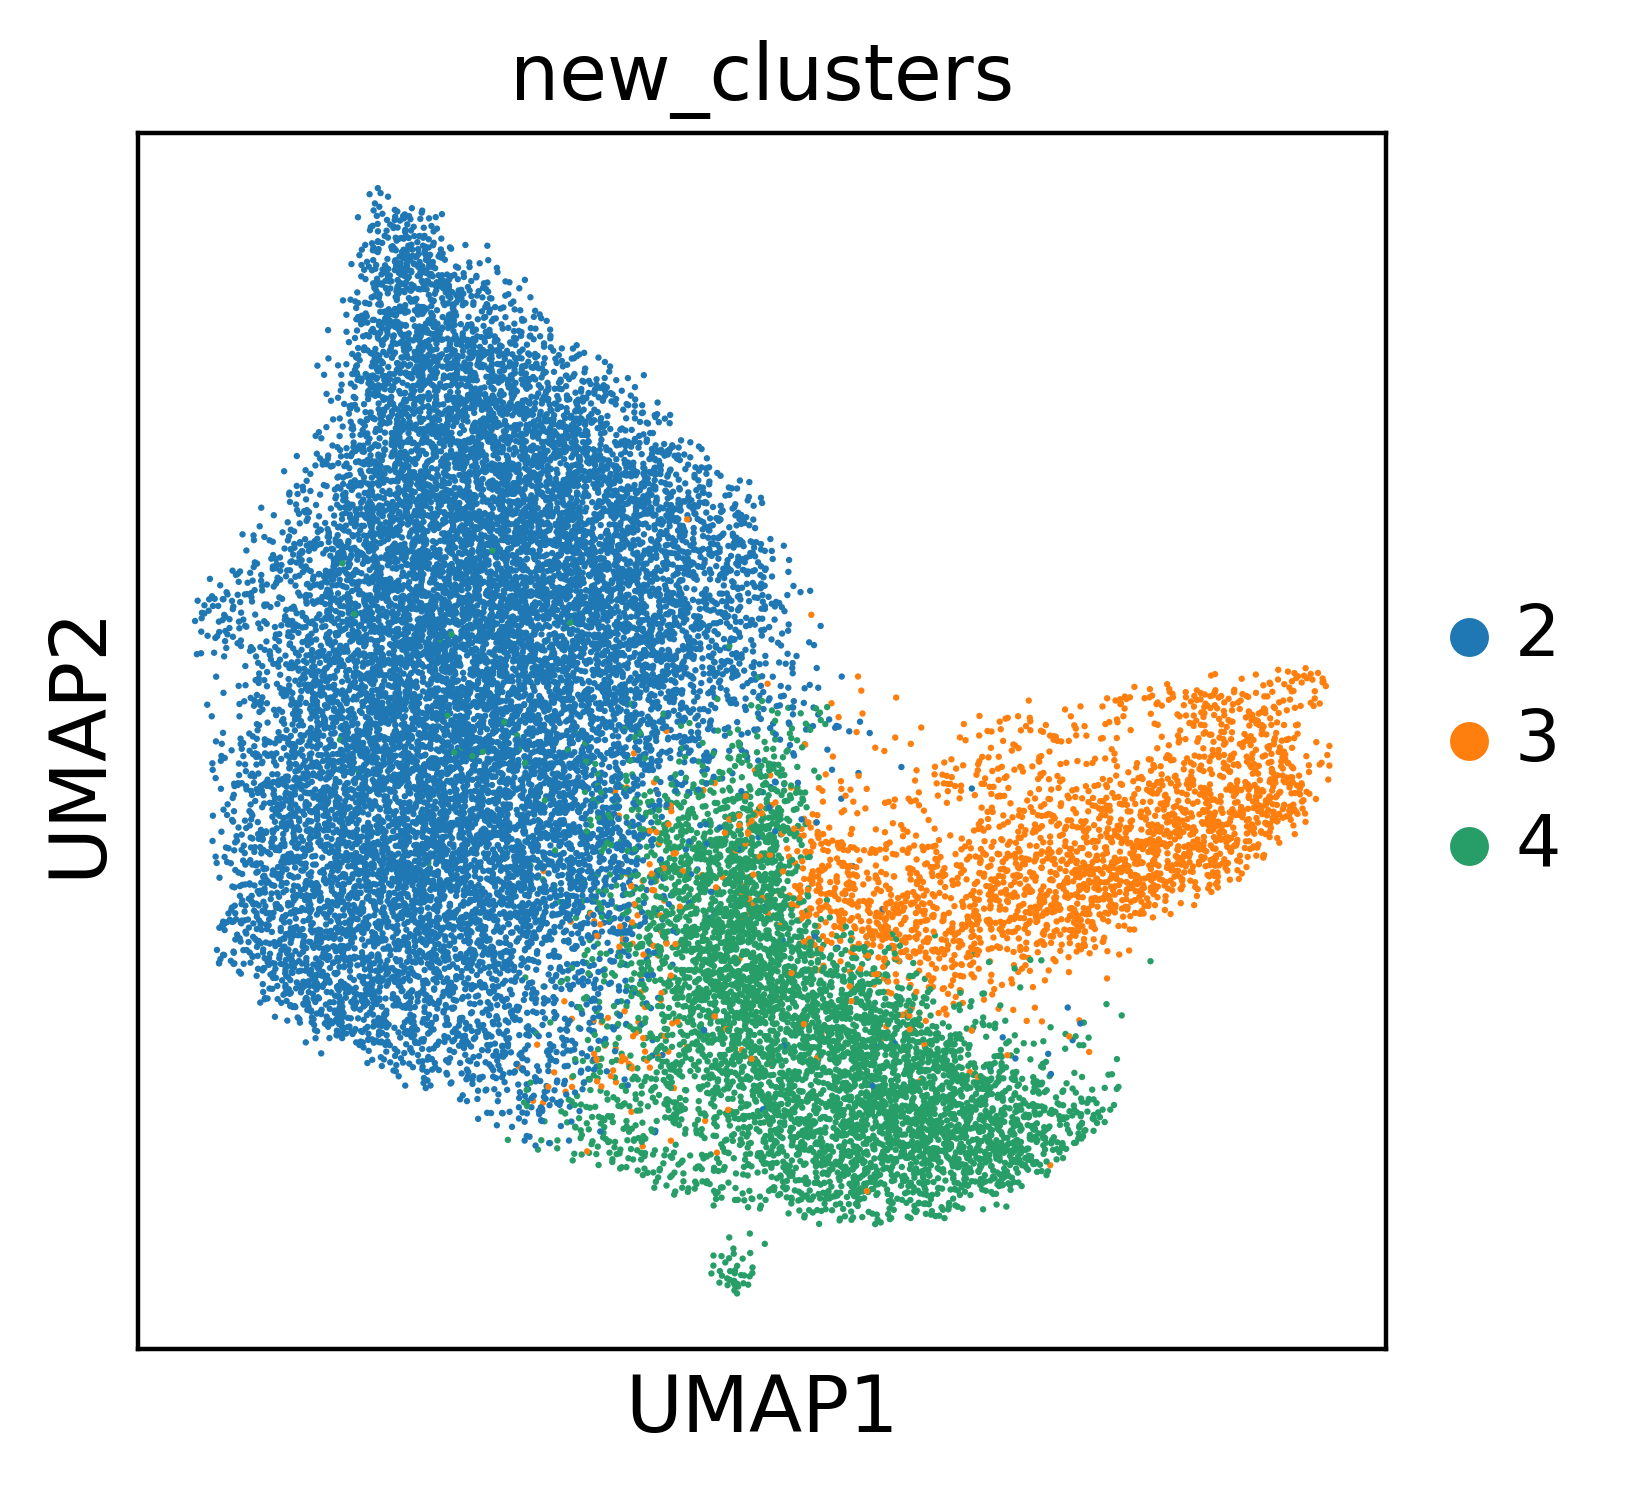

In [6]:
sc.pl.umap(adata, color=['new_clusters'])

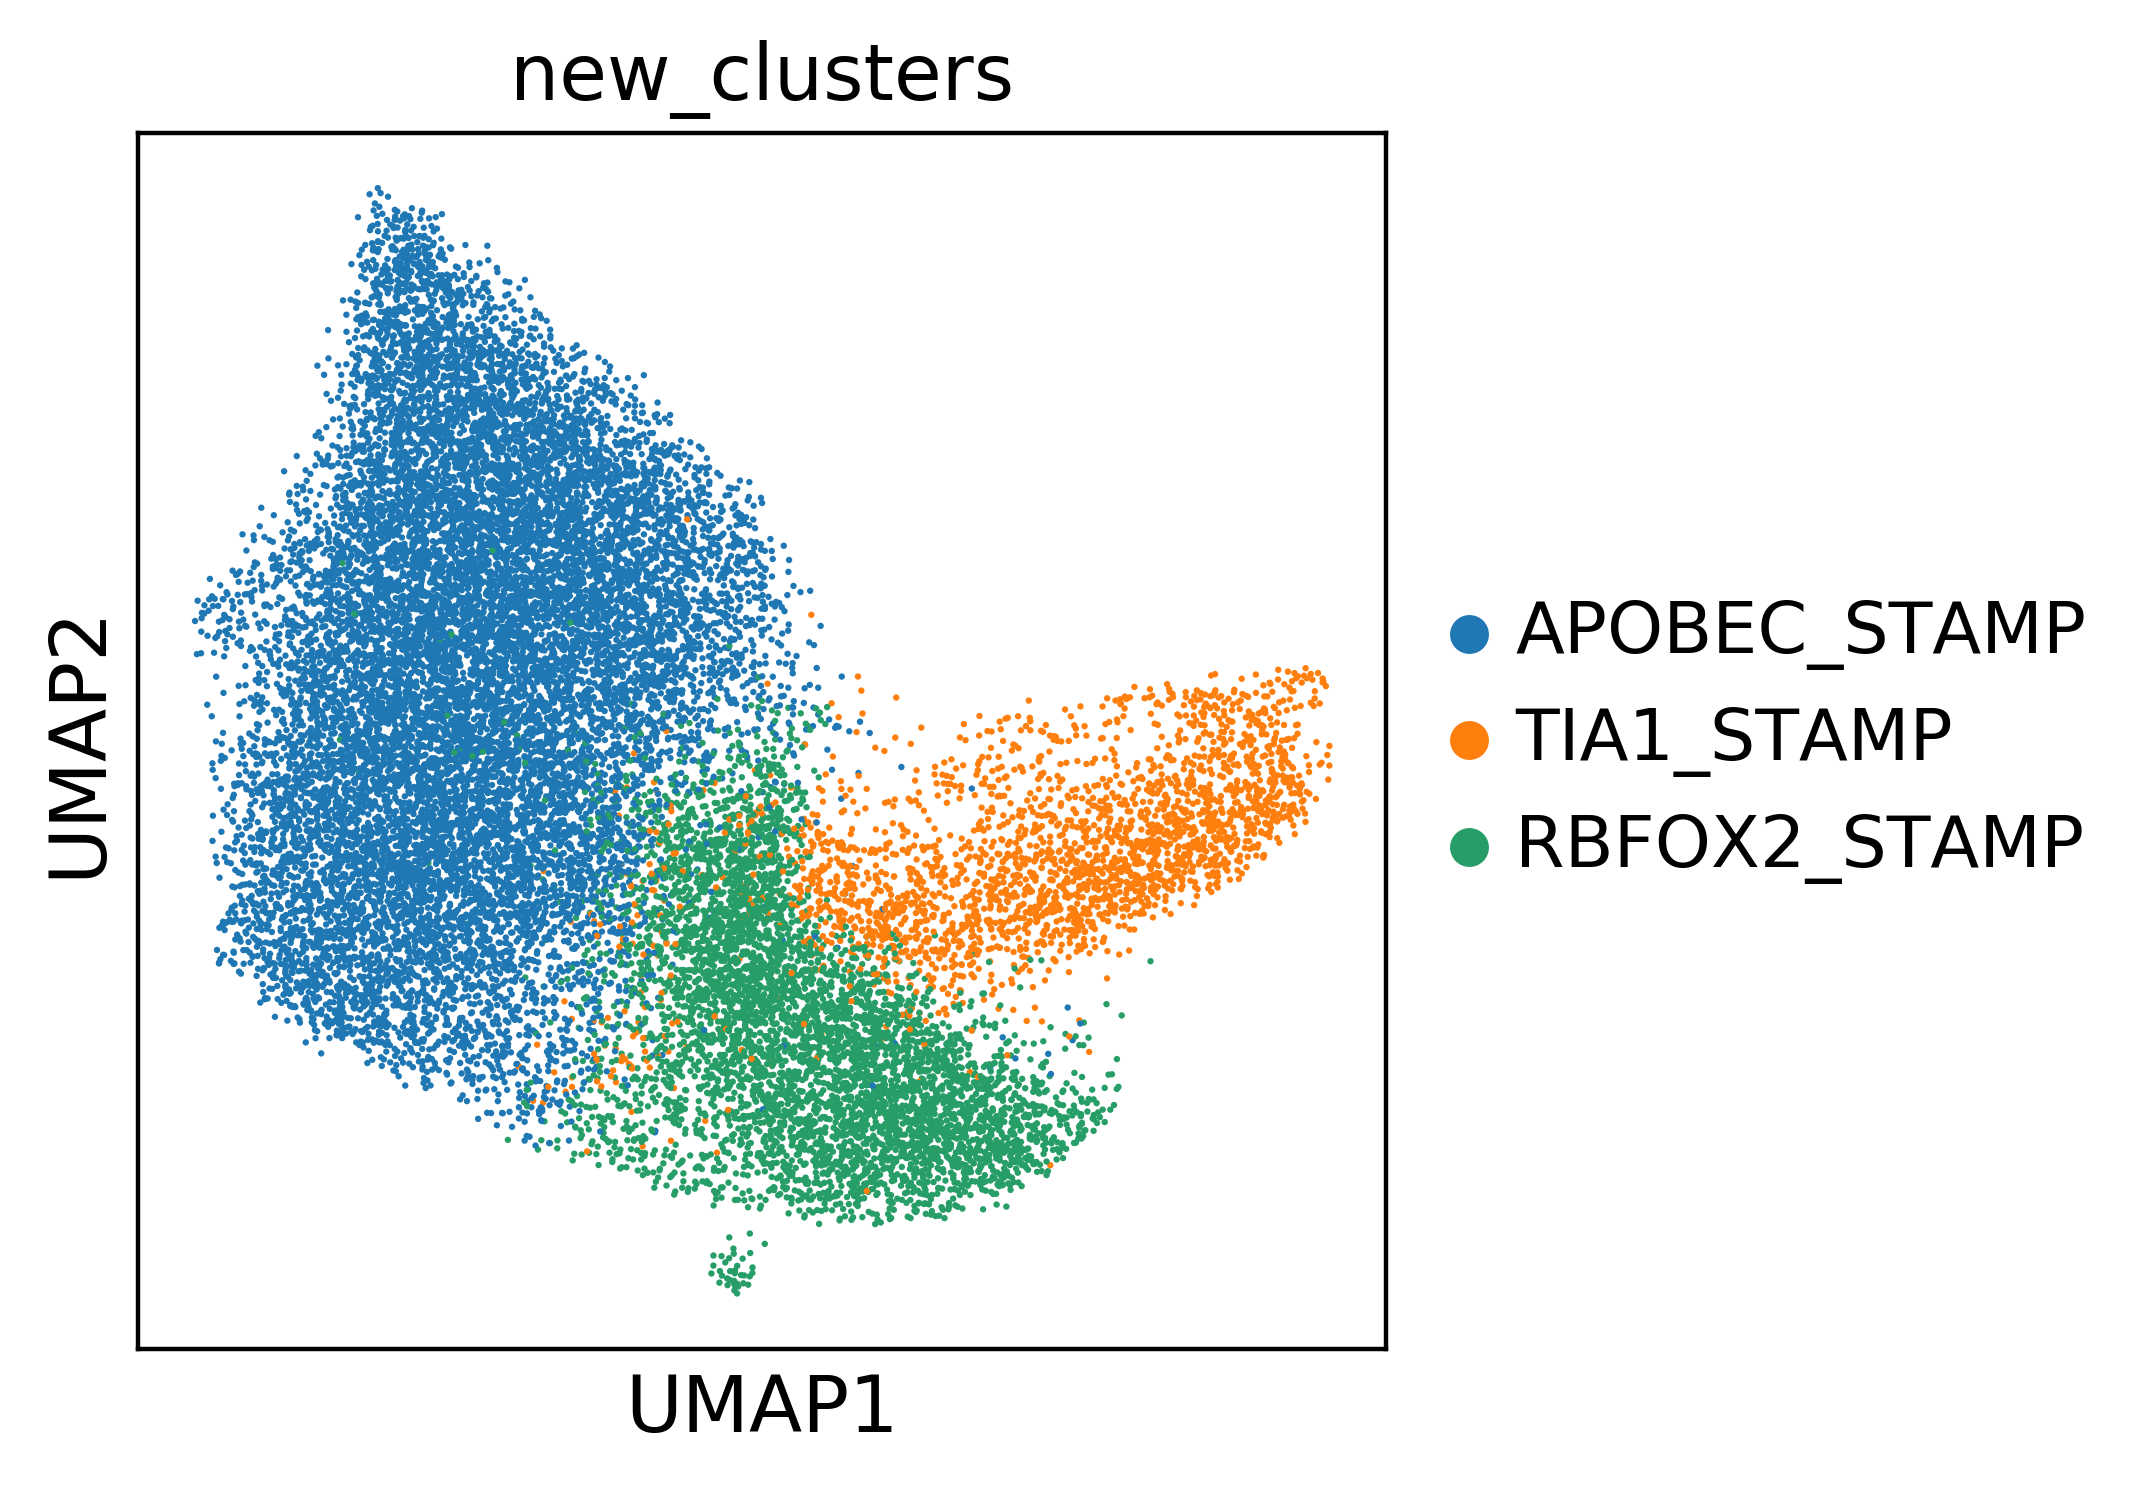

In [7]:
new_cluster_names = [
    'APOBEC_STAMP', 'TIA1_STAMP','RBFOX2_STAMP']
adata.rename_categories('new_clusters', new_cluster_names)
sc.pl.umap(adata, color=['new_clusters'])

In [8]:
sc.tl.rank_genes_groups(adata,groupby='new_clusters',method='wilcoxon',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_new_clusters']`


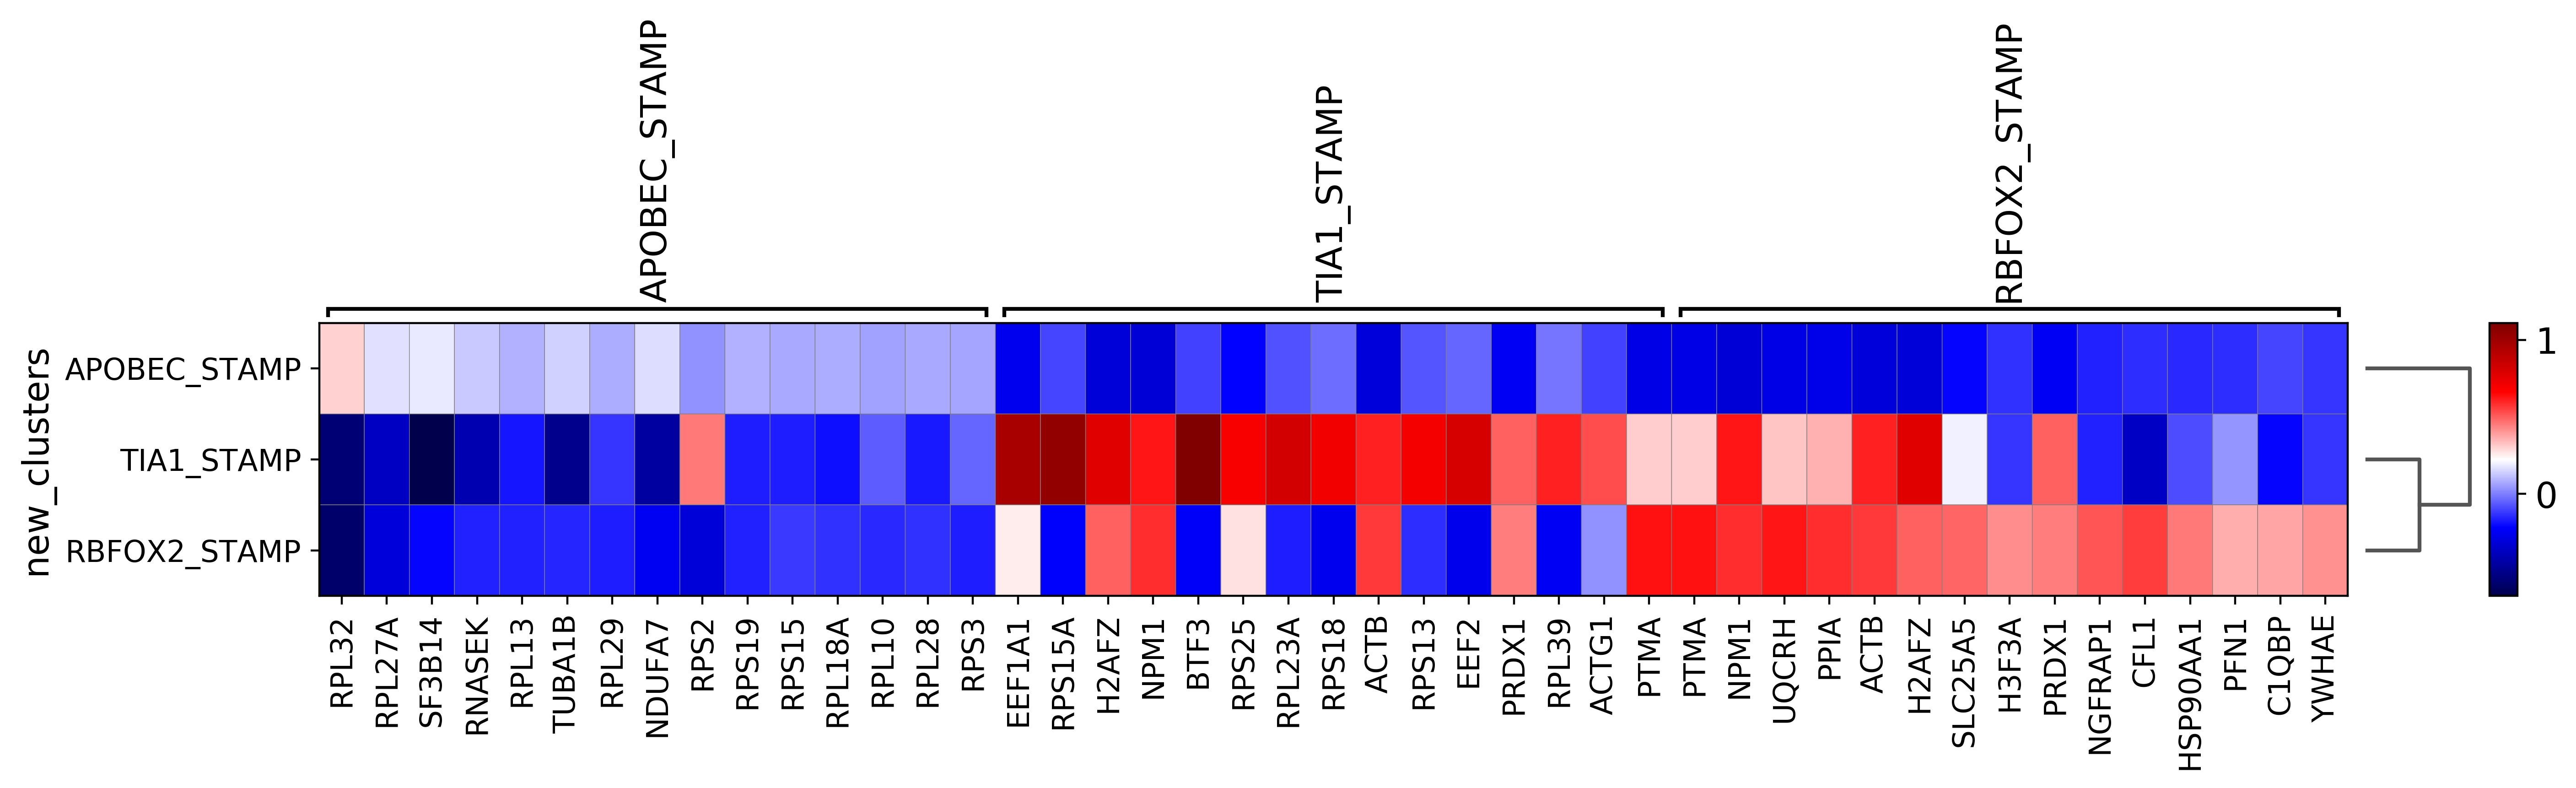

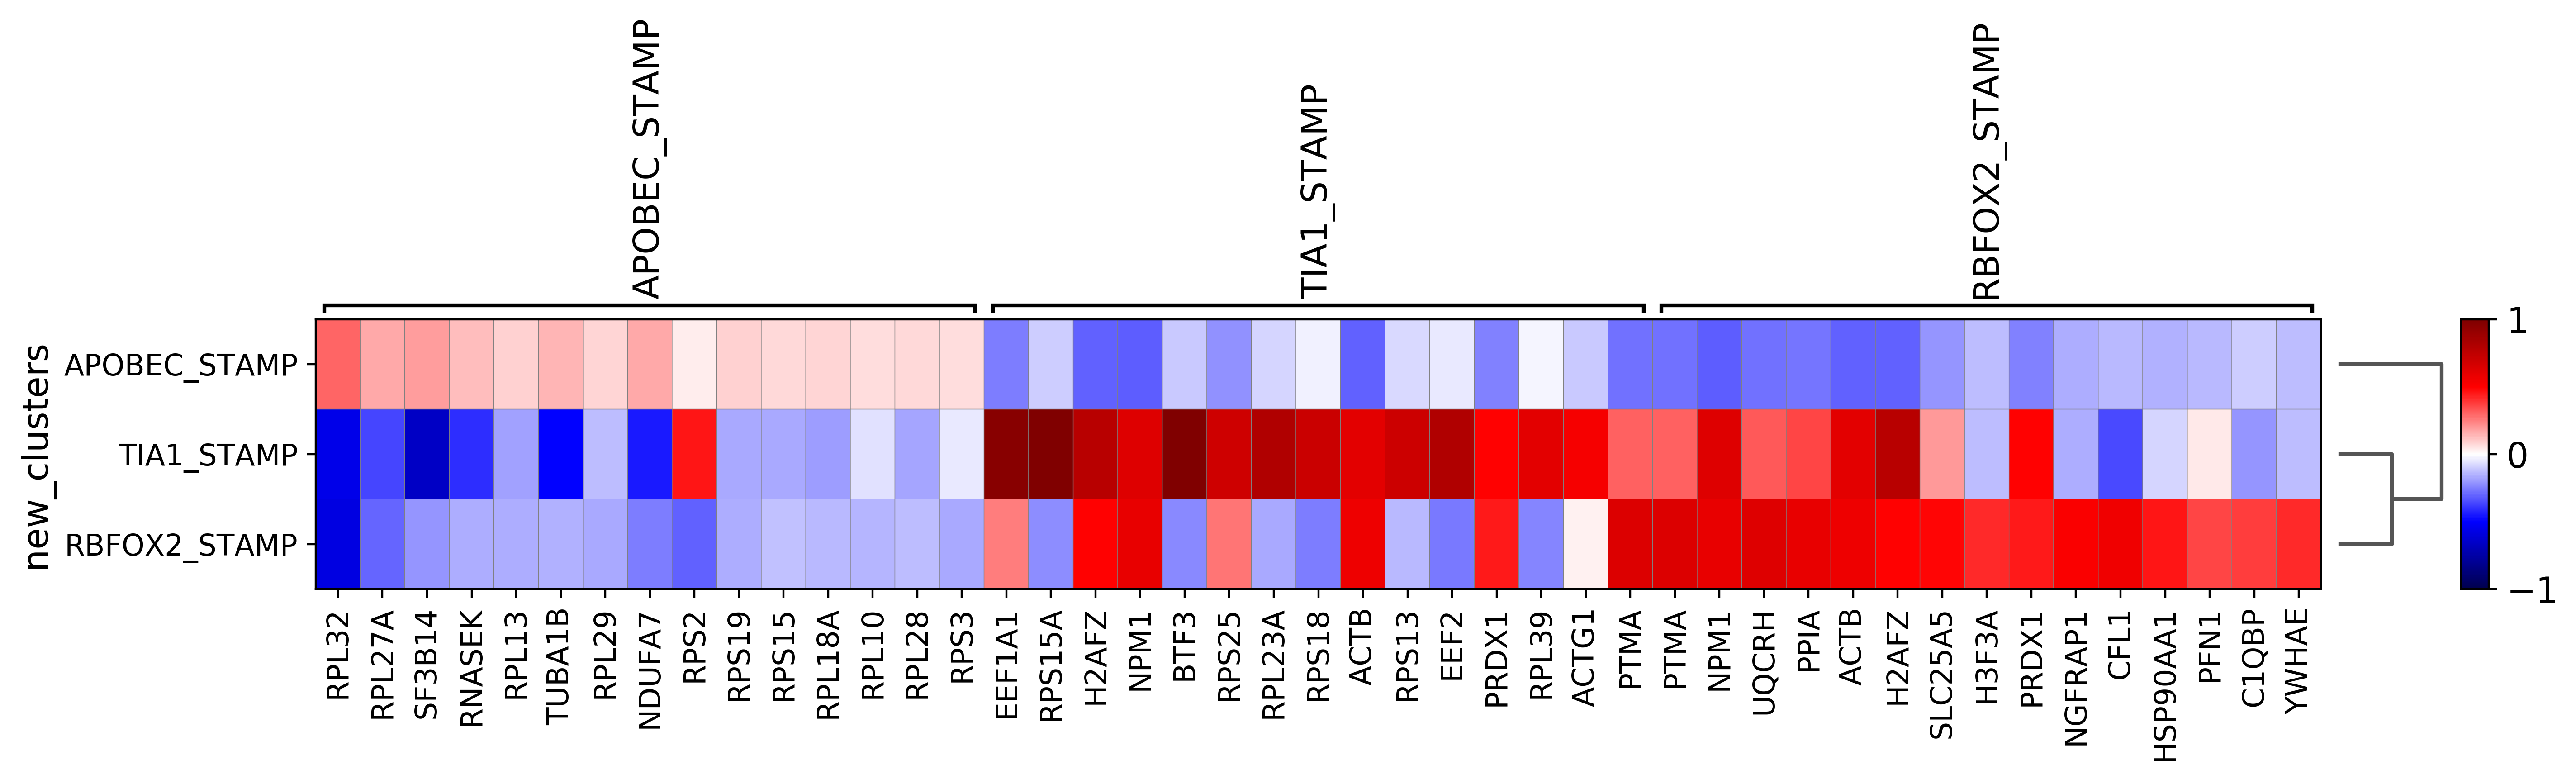

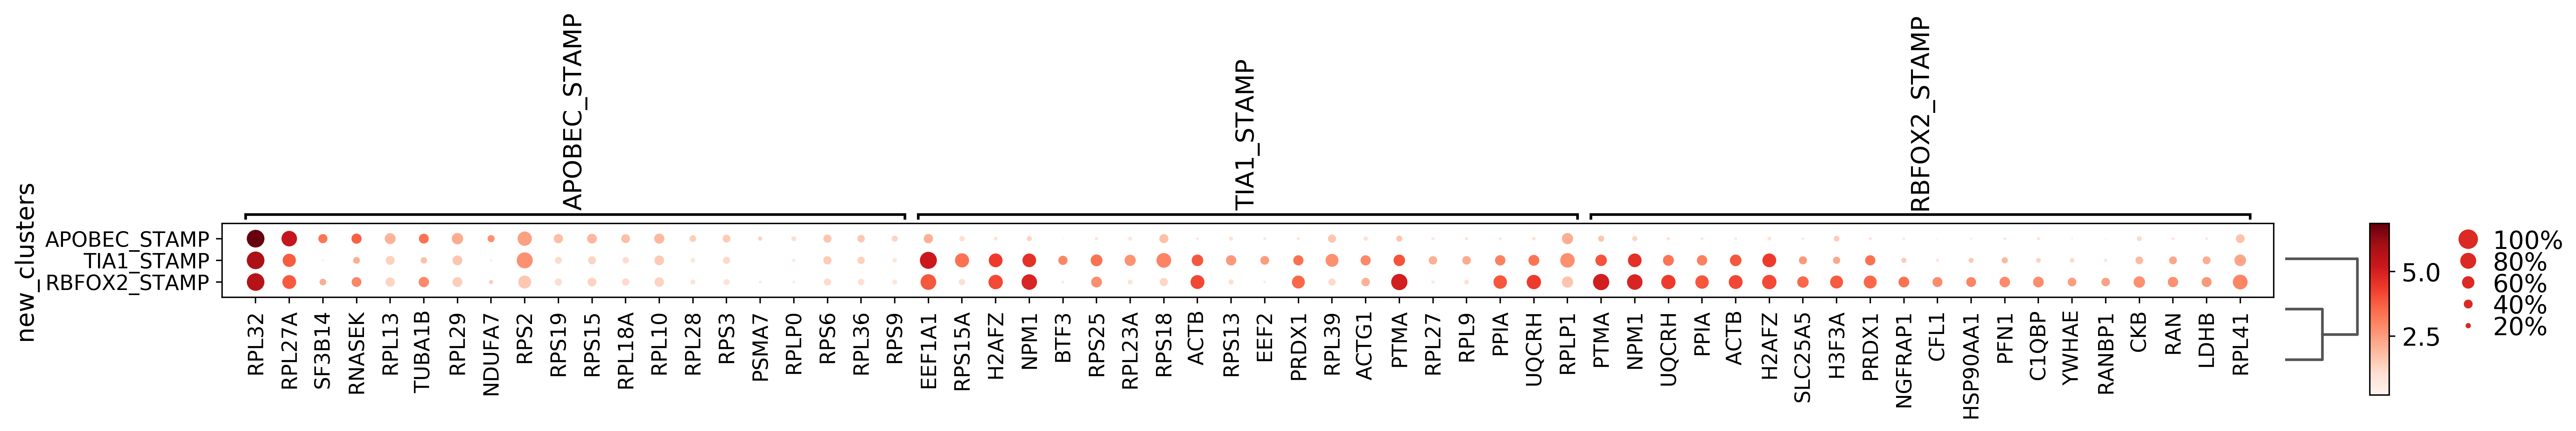

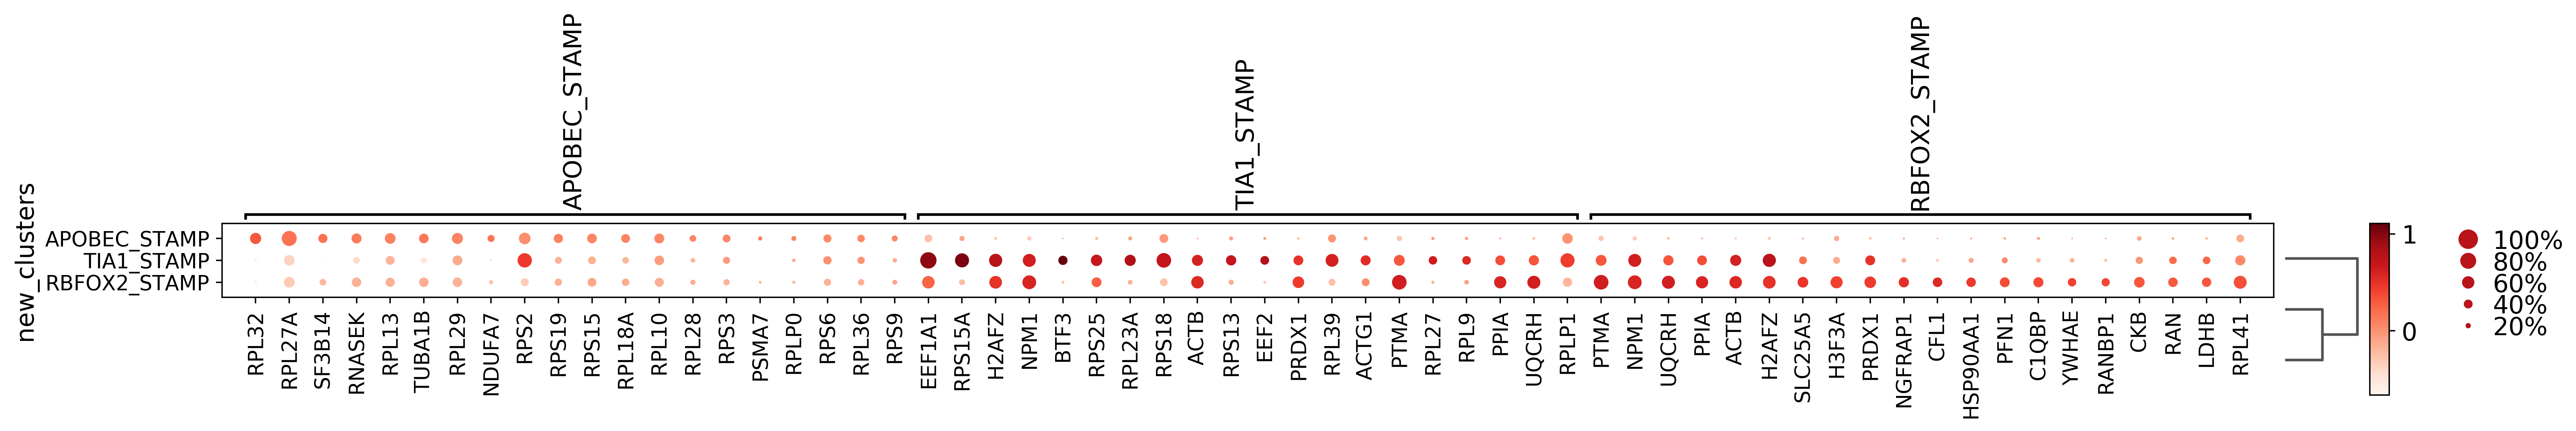

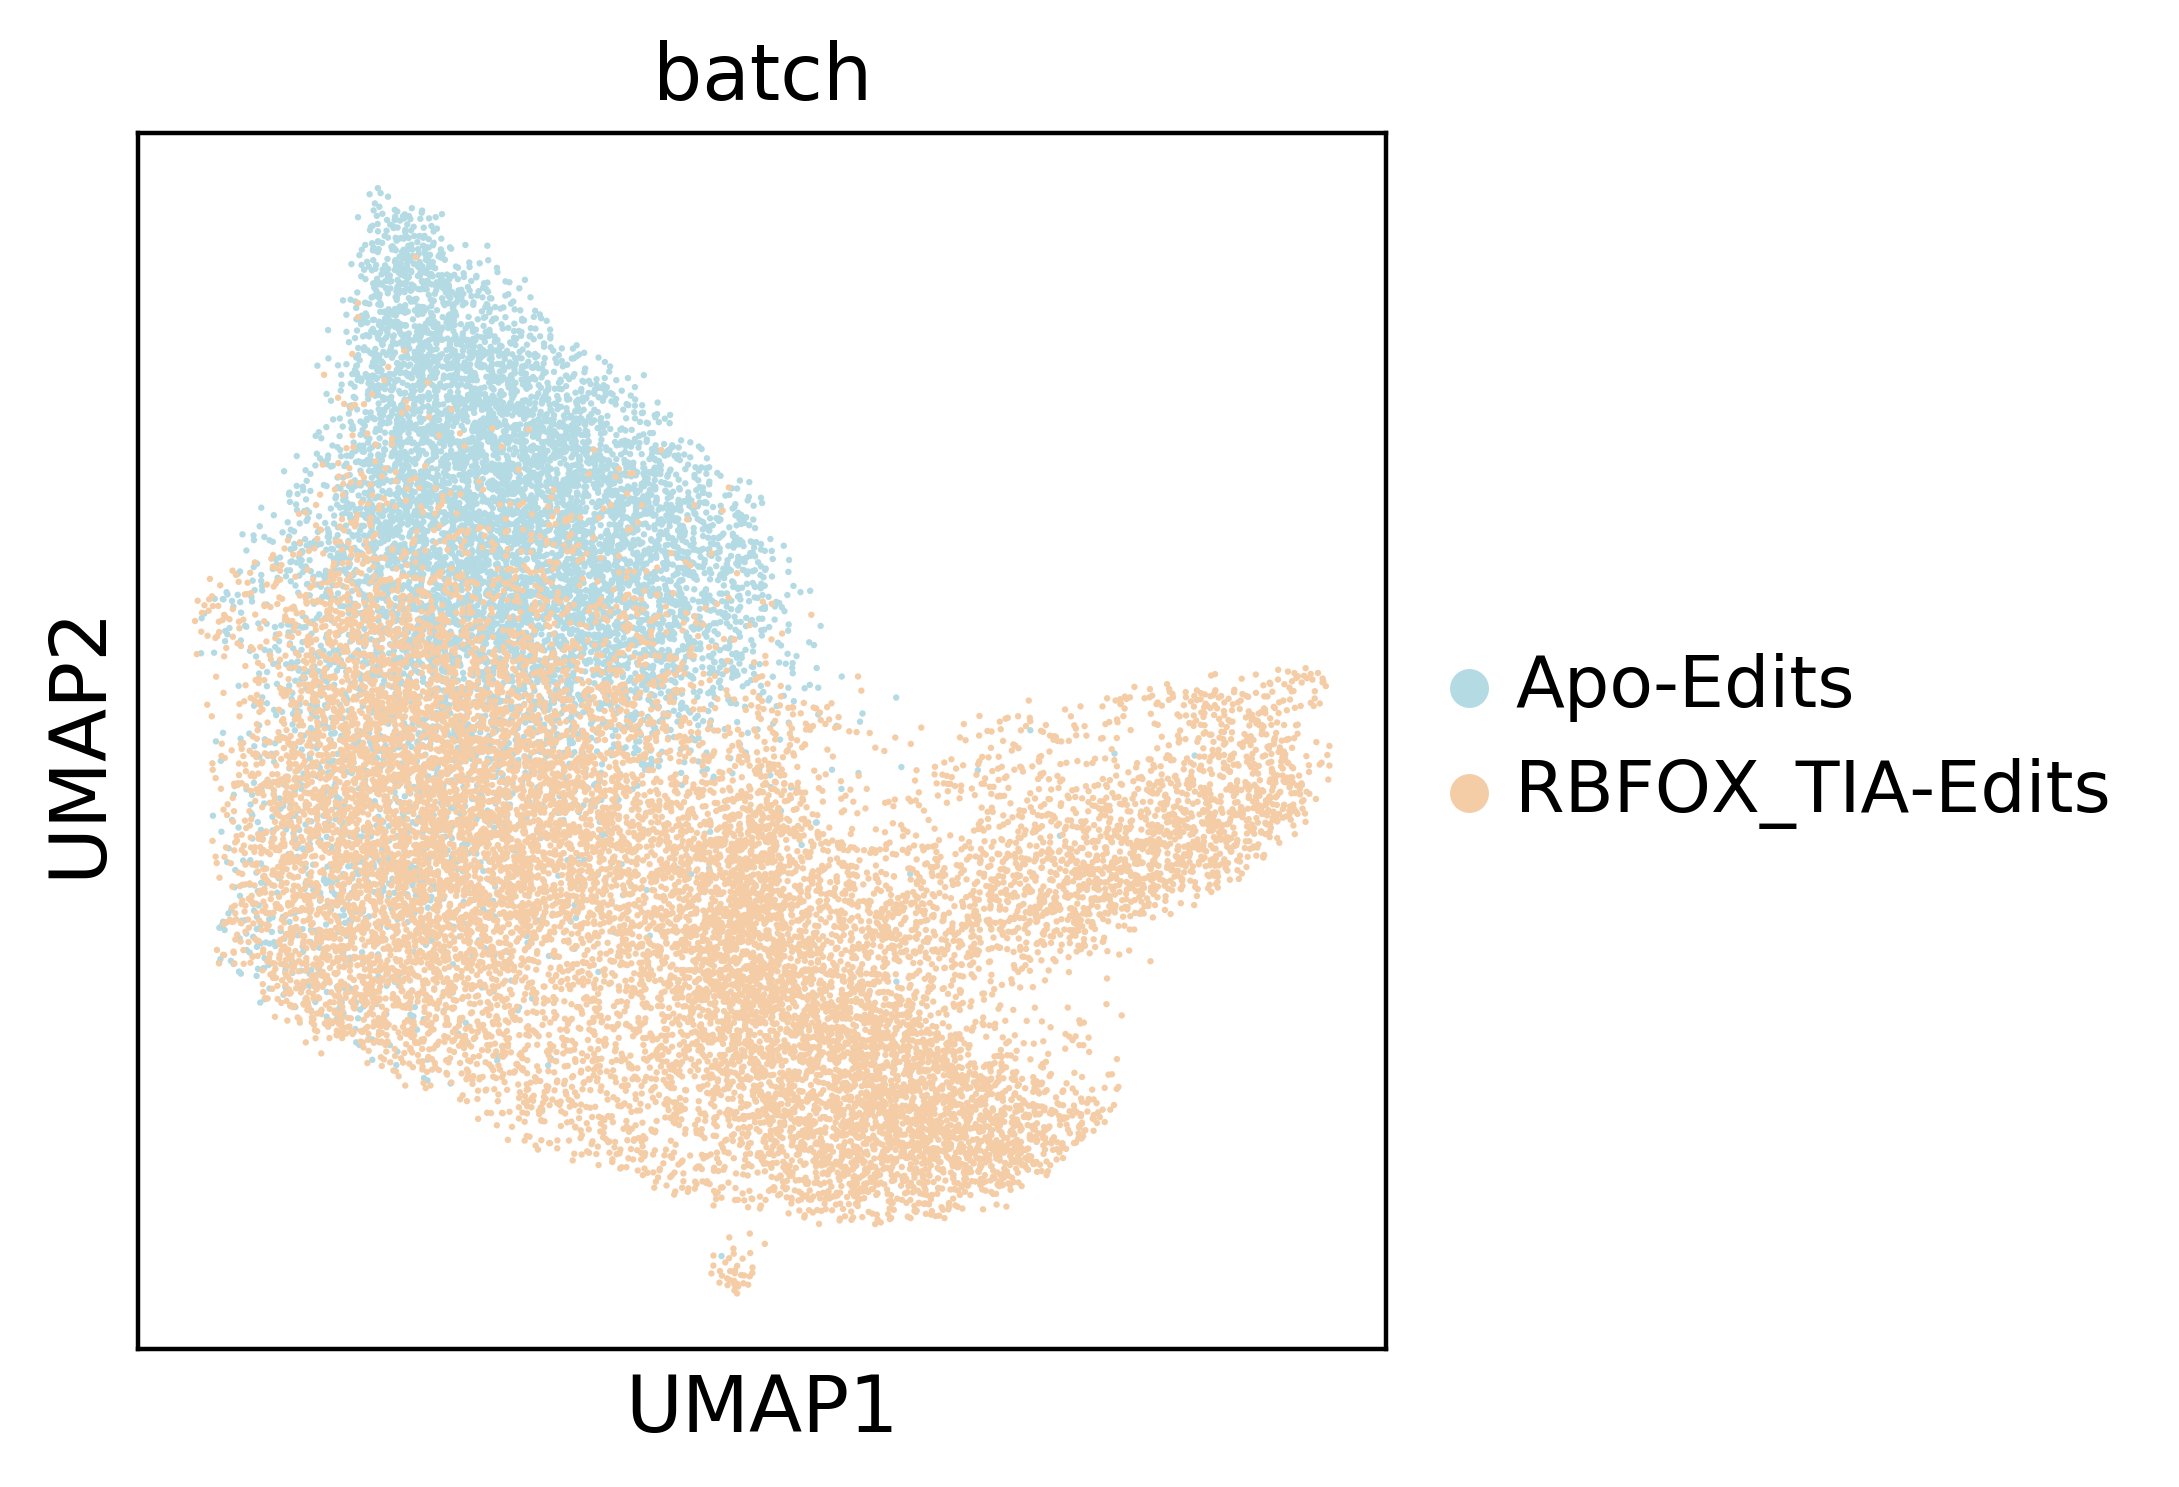

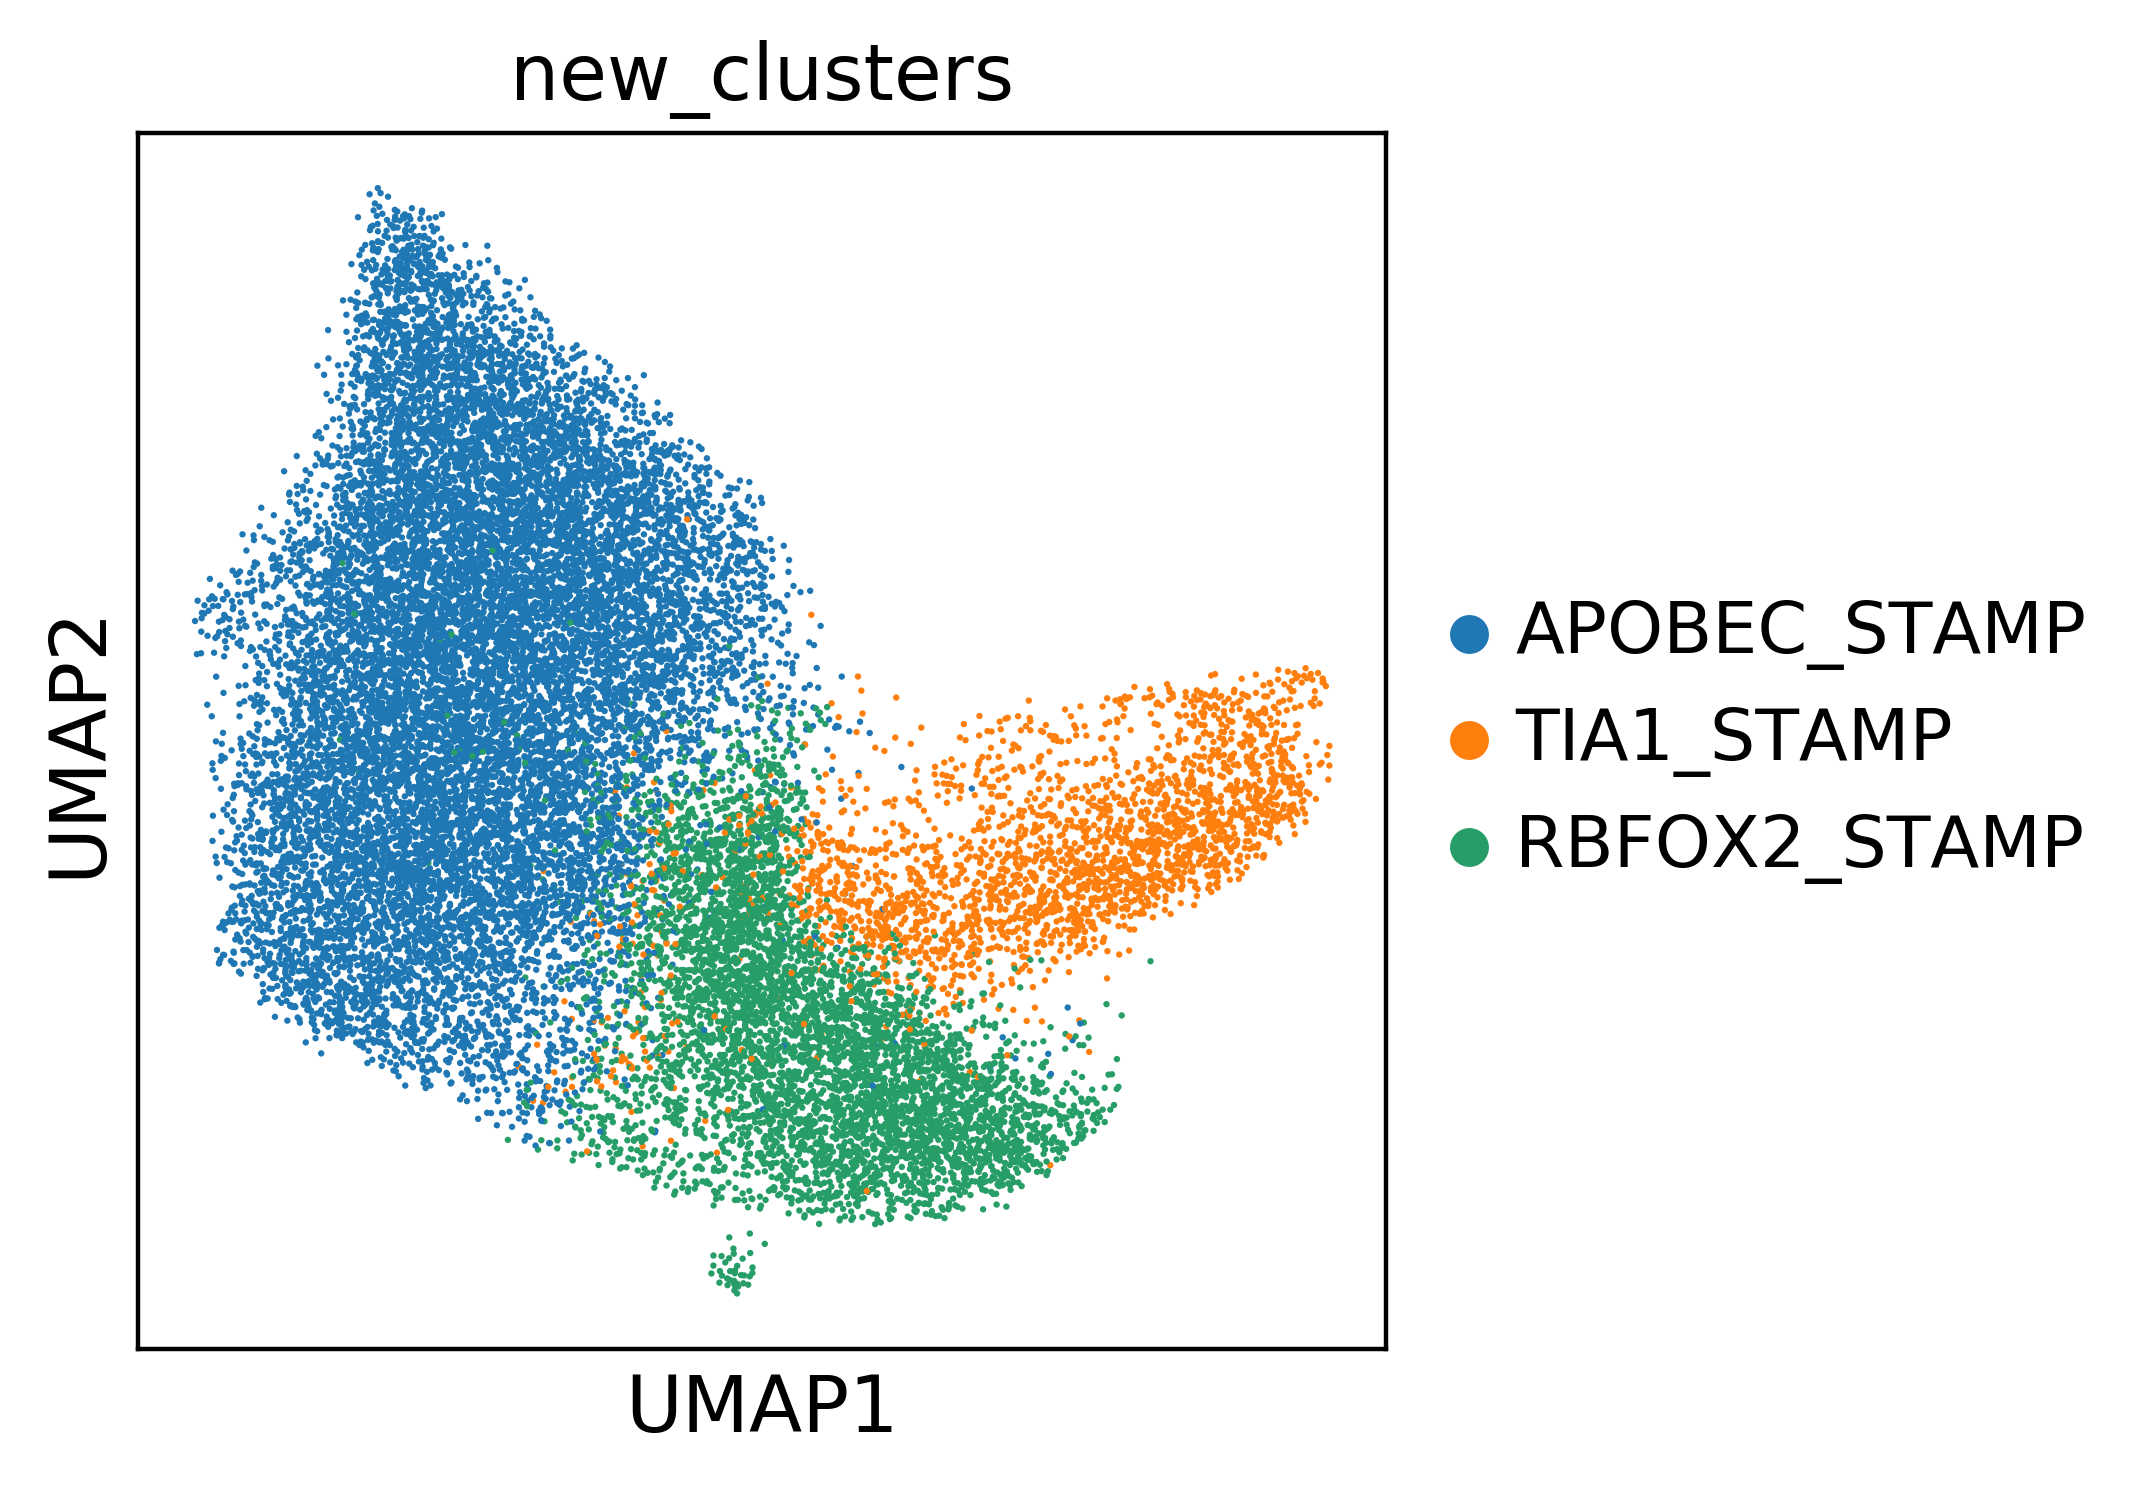

In [9]:
sc.pl.rank_genes_groups_matrixplot(adata,key='rank_genes_groups',n_genes=15,
                                   cmap='seismic', use_raw=False)
sc.pl.rank_genes_groups_matrixplot(adata,key='rank_genes_groups',n_genes=15,
                                   cmap='seismic', use_raw=False, vmin=-1, vmax=1)
sc.pl.rank_genes_groups_dotplot(adata,key='rank_genes_groups',n_genes=20)
sc.pl.rank_genes_groups_dotplot(adata,key='rank_genes_groups',n_genes=20,use_raw=False)

sc.pl.umap(adata, color=['batch'])
sc.pl.umap(adata, color=['new_clusters'])

In [10]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [11]:
n_genes = 15

top_genes = defaultdict(list)

for n in range(n_genes):
    for i, key in zip([0, 1, 2], ['APOBEC_STAMP','TIA_STAMP','RBFOX2_STAMP']):
        top_genes[key].append(adata.uns['rank_genes_groups']['names'][n][i])

genes = []
for key in ['APOBEC_STAMP','TIA_STAMP','RBFOX2_STAMP']:
    genes += top_genes[key]


In [12]:
mean = grouped_obs_mean(
    adata=adata, 
    group_key='new_clusters'
).loc[genes].T
mean

index            RPL32    RPL27A    SF3B14    RNASEK     RPL13    TUBA1B  \
APOBEC_STAMP  0.303885  0.171052  0.187516  0.128094  0.089426  0.141210   
TIA1_STAMP   -0.561301 -0.365925 -0.661917 -0.410972 -0.182155 -0.499140   
RBFOX2_STAMP -0.580466 -0.302463 -0.206763 -0.160958 -0.162508 -0.155379   

index            RPL29    NDUFA7      RPS2     RPS19  ...     H2AFZ   SLC25A5  \
APOBEC_STAMP  0.081448  0.166740  0.032931  0.086674  ... -0.310781 -0.210179   
TIA1_STAMP   -0.127915 -0.449667  0.456945 -0.169618  ...  0.773977  0.198292   
RBFOX2_STAMP -0.166193 -0.250341 -0.310658 -0.160824  ...  0.497304  0.491947   

index            H3F3A     PRDX1   NGFRAP1      CFL1  HSP90AA1      PFN1  \
APOBEC_STAMP -0.129481 -0.245653 -0.157435 -0.138205 -0.149916 -0.137135   
TIA1_STAMP   -0.125068  0.499435 -0.160503 -0.359102 -0.084094  0.039649   
RBFOX2_STAMP  0.421396  0.446860  0.516406  0.557770  0.458841  0.363926   

index            C1QBP     YWHAE  
APOBEC_STAMP -0.099817 -0.127882  
TIA1_STAMP   -0.207986 -0.125936  
RBFOX2_STAMP  0.378254  0.417346  

[3 rows x 45 columns]

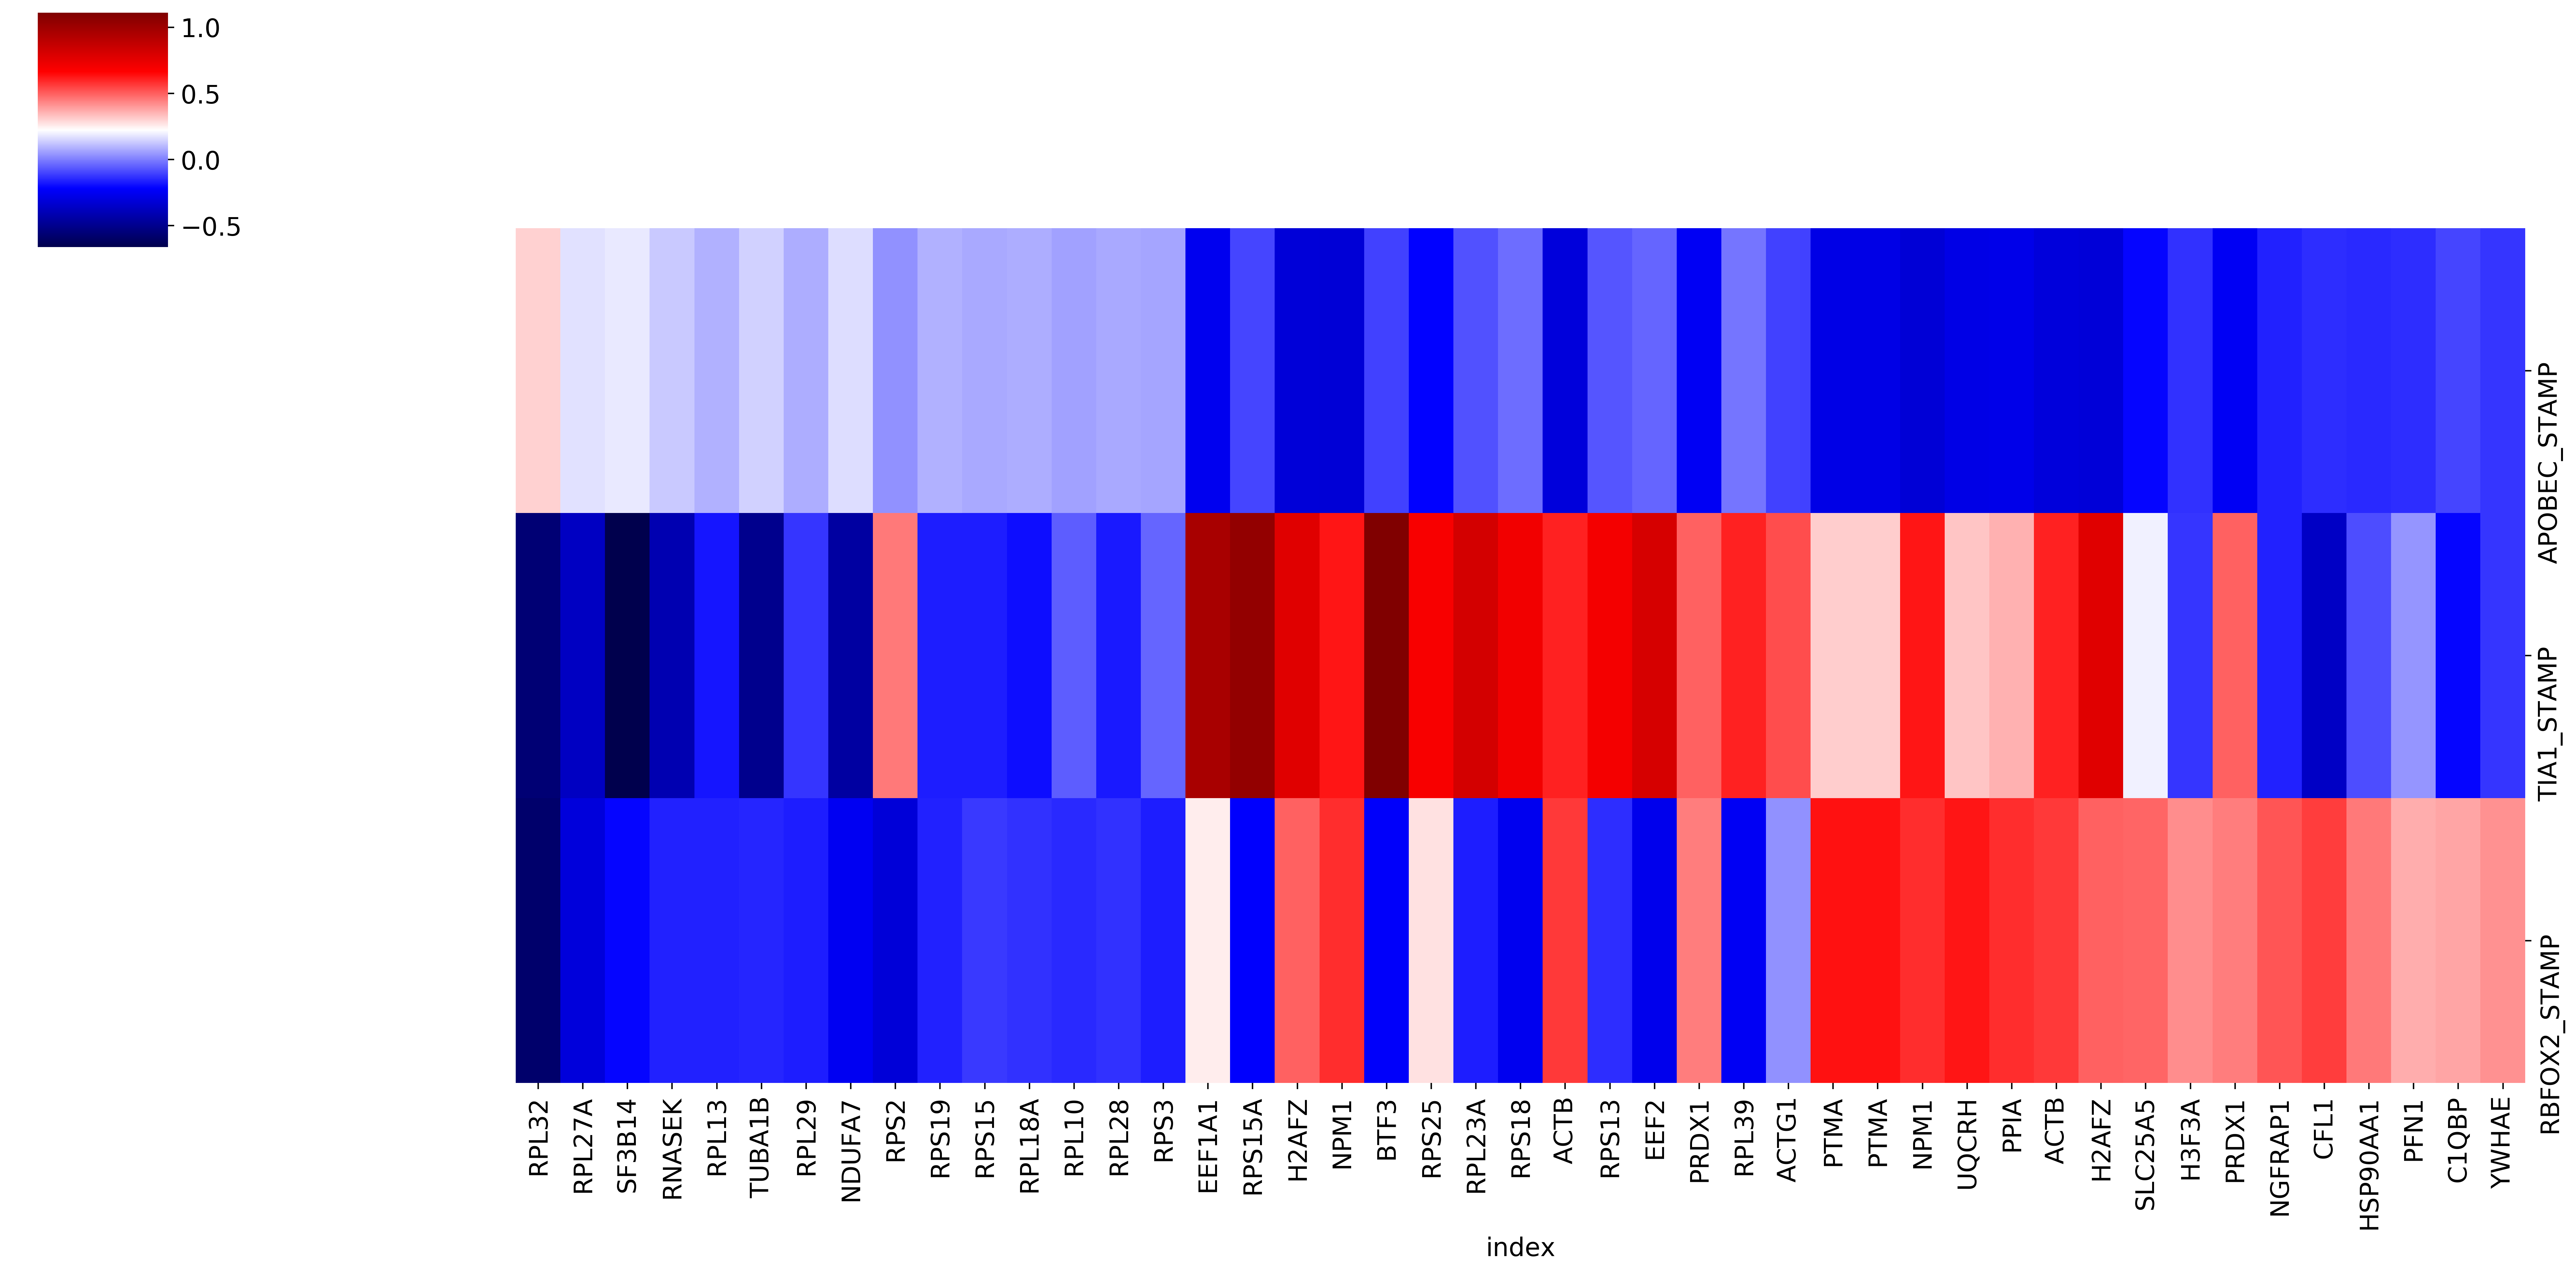

In [13]:
g = sns.clustermap(mean, row_cluster=False, col_cluster=False, cmap='seismic', figsize=(20, 10))

In [14]:
grouped = adata.obs.groupby('new_clusters')
grouped.indices.items()

dict_items([('APOBEC_STAMP', array([    0,     1,     2, ..., 22577, 22579, 22580])), ('TIA1_STAMP', array([   22,   322,   679, ..., 22566, 22581, 22583])), ('RBFOX2_STAMP', array([  106,   676,  1087, ..., 22575, 22578, 22582]))])

In [15]:
grouped.indices['APOBEC_STAMP']

array([    0,     1,     2, ..., 22577, 22579, 22580])